<a href="https://colab.research.google.com/github/luisespriella9/Deep-Learning-Advanced-Computer-Vision/blob/master/VVG_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get Google Drive Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! ls 'drive/My Drive/fruits-360'

LICENSE  readme.md  Test  Training


In [3]:
! ls 'drive/My Drive/fruits-360/Training'

'Apple Golden 1'   Banana   Lemon   Raspberry
 Avocado	   Kiwi     Mango   Strawberry


Get Data for Raspberry, Banana and Strawberry

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

Using TensorFlow backend.


In [0]:
train_path = 'drive/My Drive/fruits-360/Training'
test_path = 'drive/My Drive/fruits-360/Test'

In [0]:
# get number of files
image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# get number of classes
folders = glob(train_path + '/*')

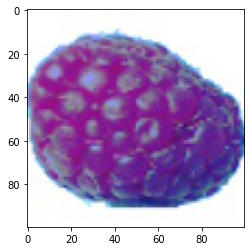

In [7]:
# look at an image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

VGG16 Layer

In [0]:
vgg = VGG16(input_shape=(100, 100, 3), weights='imagenet', include_top=False)

In [0]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [0]:
# our layers
flatten_layer_output = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(flatten_layer_output)

In [11]:
# create object model
model = Model(inputs=vgg.inputs, outputs=prediction)

# view structure of model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Image Data Generator

In [0]:
gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)

In [14]:
test_gen = gen.flow_from_directory(test_path, target_size=(100, 100))
test_gen.class_indices

Found 1285 images belonging to 8 classes.


{'Apple Golden 1': 0,
 'Avocado': 1,
 'Banana': 2,
 'Kiwi': 3,
 'Lemon': 4,
 'Mango': 5,
 'Raspberry': 6,
 'Strawberry': 7}

Test Generator

In [0]:
# label mapping
labels = [None]*len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

min:  -104.07926 max:  151.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


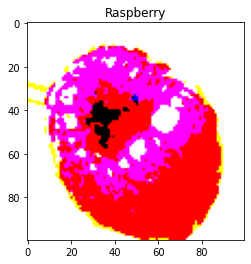

In [16]:
# get strangely colored image
for x, y in test_gen:
  print("min: ", x[0].min(), "max: ", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

Create Generator

In [17]:
train_generator = gen.flow_from_directory(train_path, target_size=(100, 100), shuffle=True, batch_size=32)
test_generator = gen.flow_from_directory(test_path, target_size=(100, 100), shuffle=True, batch_size=32)

Found 3827 images belonging to 8 classes.
Found 1285 images belonging to 8 classes.


In [18]:
r = model.fit_generator(train_generator, validation_data=test_generator, epochs = 5, steps_per_epoch=len(image_files)//32, validation_steps=len(test_image_files)//32)

Epoch 1/5
119/119 [==============================] - 22s 181ms/step - loss: 0.6046 - accuracy: 0.9478 - val_loss: 1.1004 - val_accuracy: 0.9797
Epoch 2/5
119/119 [==============================] - 22s 183ms/step - loss: 0.0503 - accuracy: 0.9924 - val_loss: 1.6018e-06 - val_accuracy: 0.9984
Epoch 3/5
119/119 [==============================] - 22s 183ms/step - loss: 0.0204 - accuracy: 0.9971 - val_loss: 3.7253e-09 - val_accuracy: 0.9984
Epoch 4/5
119/119 [==============================] - 22s 181ms/step - loss: 0.0098 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 0.9976
Epoch 5/5
119/119 [==============================] - 21s 179ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 1.4901e-08 - val_accuracy: 0.9992


In [0]:
def get_confusion_matrix(data_path, N):
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=(100, 100), shuffle=False, batch_size=32):
    i += 1
    prediction = model.predict(x)
    prediction = np.argmax(prediction, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, prediction))
    targets = np.concatenate((targets, y))
    if (len(targets) >= N):
      break
  cm = confusion_matrix(targets, predictions)
  return cm

In [20]:
cm = get_confusion_matrix(train_path, len(image_files))
cm

Found 3827 images belonging to 8 classes.


array([[480,   0,   0,   0,   0,   0,   0,   0],
       [  0, 426,   0,   0,   0,   1,   0,   0],
       [  0,   0, 490,   0,   0,   0,   0,   0],
       [  0,   0,   0, 466,   0,   0,   0,   0],
       [  0,   0,   0,   0, 492,   0,   0,   0],
       [  0,   0,   0,   0,   0, 490,   0,   0],
       [  0,   0,   0,   0,   0,   0, 490,   0],
       [  0,   0,   0,   0,   0,   0,   0, 492]])

In [21]:
test_cm = get_confusion_matrix(test_path, len(test_image_files))
test_cm

Found 1285 images belonging to 8 classes.


array([[159,   0,   0,   0,   1,   0,   0,   0],
       [  0, 143,   0,   0,   0,   0,   0,   0],
       [  0,   0, 166,   0,   0,   0,   0,   0],
       [  0,   0,   0, 156,   0,   0,   0,   0],
       [  0,   0,   0,   0, 164,   0,   0,   0],
       [  0,   0,   0,   0,   0, 166,   0,   0],
       [  0,   0,   0,   0,   0,   0, 166,   0],
       [  0,   0,   0,   0,   0,   0,   0, 164]])

Plot Results

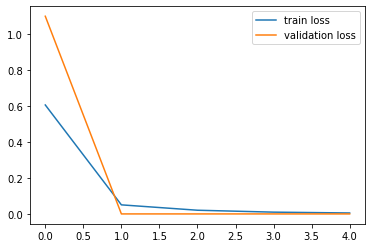

In [22]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

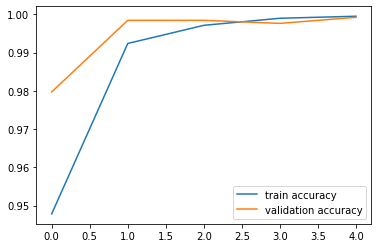

In [23]:
# accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()